# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: April 12, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.
 
이 튜토리얼과 관련된 노트북은 [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb)에서 볼 수 있습니다.

SciDataTool 개체의 기능과 사용을 입증하기 위해 FEMM을 사용하여 시뮬레이션을 실행하고 전류를 가하고 실행 시간을 줄이기 위해 주기성과 병렬화를 사용합니다.

In [2]:
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Output import Output
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from pyleecan.Classes.OPdq import OPdq

# Load the machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))

# Simulation initialization
simu = Simu1(name="FEMM_periodicity", machine=Toyota_Prius)


simu.input = InputCurrent(
#    Na_tot=252 * 8,
#    Nt_tot=50 * 8,
    Na_tot=5 * 2 ** 8, Nt_tot=120
)
# Set Id/Iq according to I0/Phi0
simu.input.OP = OPdq(N0=1000)
simu.input.OP.set_I0_Phi0(I0=250 / sqrt(2), Phi0=140*pi/180)

# Definition of the magnetic simulation: with periodicity
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=4)
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True,is_agsf_transfer=True,max_wavenumber_transfer=96)

# Run simulations
out = simu.run()

[17:02:19] Starting running simulation FEMM_periodicity (machine=Toyota_Prius)
[17:02:19] Starting Magnetic module
[17:02:19] Solving time step 1 / 15 in FEMM
[17:02:19] Solving time step 9 / 15 in FEMM
[17:02:19] Solving time step 13 / 15 in FEMM
[17:02:19] Solving time step 5 / 15 in FEMM
[17:02:20] Solving time step 2 / 15 in FEMM
[17:02:20] Solving time step 10 / 15 in FEMM
[17:02:20] Solving time step 14 / 15 in FEMM
[17:02:20] Solving time step 6 / 15 in FEMM
[17:02:20] Solving time step 3 / 15 in FEMM
[17:02:20] Solving time step 11 / 15 in FEMM
[17:02:21] Solving time step 15 / 15 in FEMM
[17:02:21] Solving time step 7 / 15 in FEMM
[17:02:21] Solving time step 12 / 15 in FEMM
[17:02:21] Solving time step 4 / 15 in FEMM
[17:02:21] Solving time step 8 / 15 in FEMM
[17:02:21] Starting Force module
[17:02:22] End of simulation FEMM_periodicity


In [3]:
from pyleecan.Functions.Plot import dict_2D, dict_3D



## 포스 모듈
Force 추상 클래스를 사용하면 힘을 계산하는 다양한 방법을 정의할 수 있습니다.

ForceMT 클래스는 Force 클래스에서 상속됩니다. ForceMT는 Maxwell 응력 텐서 \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]를 기반으로 하는 공극 표면력 계산에 전념합니다.

여기서 우리는 힘 계산 없이 자기 시뮬레이션의 결과를 얻습니다. Force 모듈은 초기화되고 단독으로 실행됩니다.

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT

# Create the Simulation
mySimu = Simu1(name="Tuto_Force")  
mySimu.parent = out
mySimu.force = ForceMT()

# Run only the force module
#out_mySimu=mySimu.force.run()
   

시뮬레이션이 완료되면 결과가 출력의 force 부분(예: _myResults.force_ )에 저장되고 다른 플롯을 호출할 수 있습니다. 이 개체에는 다음이 포함됩니다.
- *시간*: 시간 축
- *각도*: 각도 위치 축
- *AGSF*: 에어갭 표면력(방사형 및 접선 성분)
    
**출력** 개체는 결과를 쉽게 시각화하기 위해 다른 플롯을 포함합니다. 전용 튜토리얼은 [여기](https://www.pyleecan.org/tuto_Plots.html)에서 찾을 수 있습니다.

다음은 유용한 플롯의 몇 가지 예입니다.

C:\ProgramData\Anaconda3\envs\py38_pylee\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


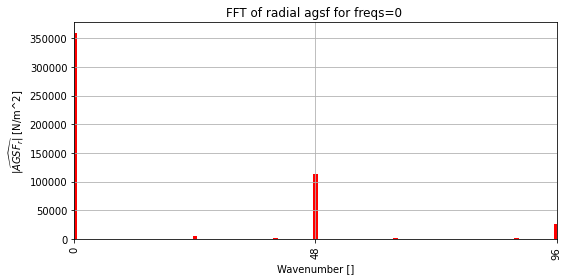

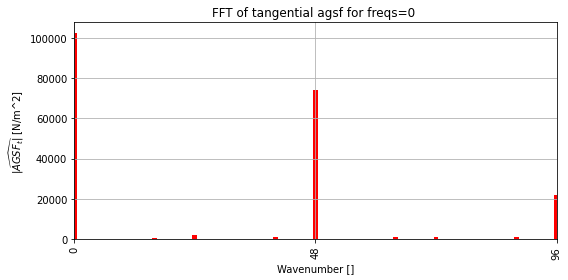

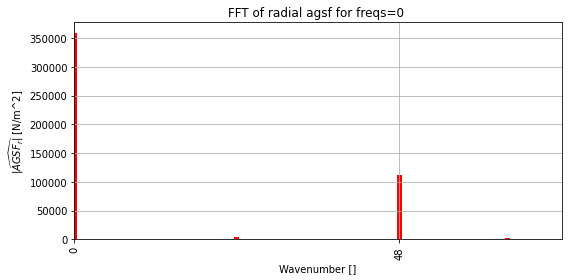

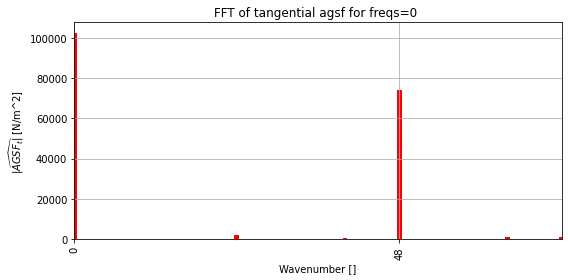

In [5]:
from pyleecan.Functions.Plot import dict_2D, dict_3D
#axis_data=out.force.AGSF.get_axes()
#out.force.AGSF.plot_2D_Data_Animated("time",save_path="D:/AGSF.gif")

#("freqs", "angle[0]")
#mySimu.parent.force.AGSF.plot_2D_Data("angle{°}", **dict_2D)
mySimu.parent.force.AGSF.plot_2D_Data("wavenumber=[0,96]", **dict_2D)
out.force.AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)
#out.force.AGSF.plot_2D_Data("angle{°}", **dict_2D)


In [6]:
axis_data=[]

C:\ProgramData\Anaconda3\envs\py38_pylee\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\ProgramData\Anaconda3\envs\py38_pylee\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


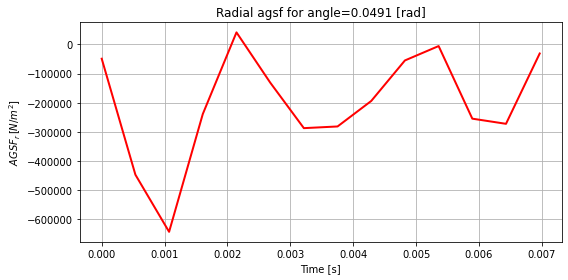

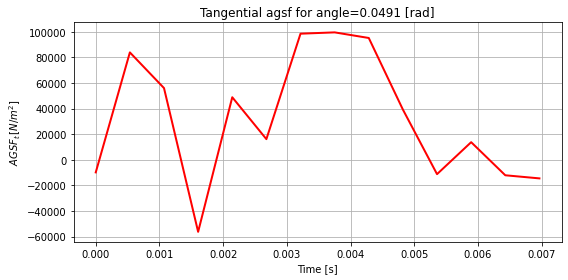

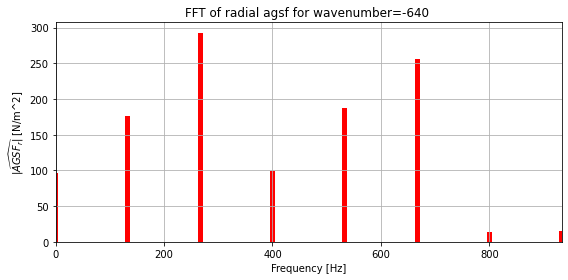

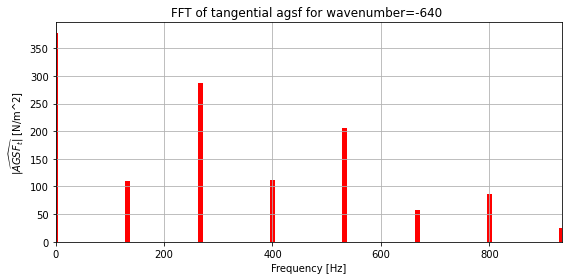

In [7]:
from numpy import pi

#------------------------------------------------------
# Plot the air-gap force as a function of time with the time fft
out.force.AGSF.plot_2D_Data("time","angle[10]", is_auto_ticks=False, **dict_2D)
out.force.AGSF.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False, **dict_2D)
#------------------------------------------------------

다음 플롯은 시간과 각도에 따른 방사형 에어 갭 표면력을 표시합니다.

The following plot displays the radial air-gap surface force over time and angle. 

C:\ProgramData\Anaconda3\envs\py38_pylee\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


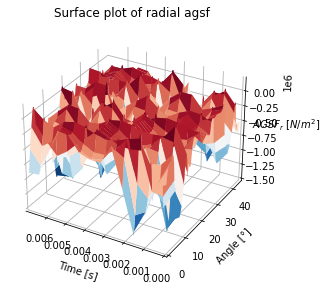

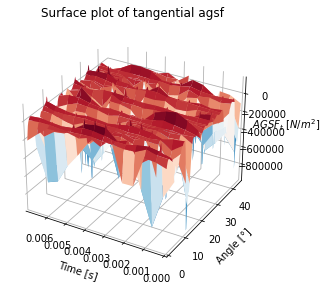

In [8]:
#------------------------------------------------------
# Plot the tangential force as a function of time and space
#out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.06, **dict_3D)
out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)
#------------------------------------------------------

[추가] 방사방향 자속밀도 2D FFT

C:\ProgramData\Anaconda3\envs\py38_pylee\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


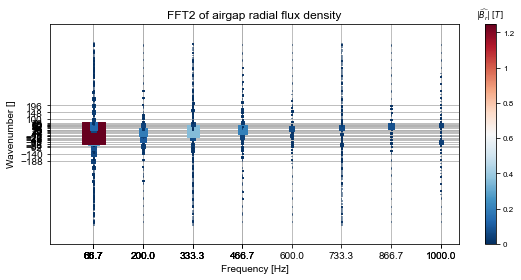

In [9]:
out.mag.B.plot_3D_Data("mag.B", "freqs","wavenumber", component_list=['radial'], is_2D_view=True)

[추가] 방사방향 전자기력 2D FFT

In [10]:
out.force.AGSF.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)

UnitError: Prefix mec unknown